## **Yale Face aAPCA Reconstruction** - Removing Shadows

File name:  yale_face_apca_resconstruction.ipynb

Author:  Billy Carson

Date created:  07-26-2020

Last modified:  06-05-2021

> Description:  Uses aAPCA to reconstruct images from the Extended Yale Face Dataset B.


### **Import modules**

In [1]:
# Import modules
import os
import numpy as np
import time
import PIL
from PIL import Image
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from umap import UMAP
from apca.models import *
from apca.metrics import *

# Import data loading functions
from load_data import *
from preprocessing import *

# Define random state
random_state = 0


### **Function definitions**

In [2]:
# Plot example reconstructions
def plot_recon_ex(example_idx_list, scaler, figsize=(14, 10), sup_title=None, save_path=None, dpi=300):
    r"""
    """
    
    # Initialize figure
    fig, ax = plt.subplots(nrows=3, ncols=X_test_scaled[example_idx_list, :].shape[0], figsize=figsize)

    # Iterate over test instances
    for i, example_idx in enumerate(example_idx_list):
        # Original image
        img_orig_arr = X_test_scaled[[example_idx], :]
        img_orig_arr = scaler.inverse_transform(img_orig_arr)
        img_orig_arr = np.reshape(img_orig_arr, newshape=(img_height, img_width))
        img_orig = Image.fromarray(img_orig_arr)

        # PCA image reconstruction
        img_recon_pca_arr = S_pca[[example_idx], :] @ pca.components_ + scaler.data_scaled_mean_
        img_recon_pca_arr = scaler.inverse_transform(img_recon_pca_arr)
        img_recon_pca_arr = np.reshape(img_recon_pca_arr, newshape=(img_height, img_width))
        img_recon_pca_arr = ref_img_adjust(img_orig_arr, img_recon_pca_arr, ccmt=Y_test_scaled[[example_idx], :],
                                           ccmt_thresh=0.5, copy=True)
        img_recon_pca = Image.fromarray(img_recon_pca_arr)

        # Local aPCA image reconstruction
        img_recon_aapca_arr, _ = aapca.reconstruct(X_test_scaled[[example_idx], :], Y_test_scaled[[example_idx], :])
        img_recon_aapca_arr = scaler.inverse_transform(img_recon_aapca_arr)
        img_recon_aapca_arr = np.reshape(img_recon_aapca_arr, newshape=(img_height, img_width))
        img_recon_aapca_arr = ref_img_adjust(img_orig_arr, img_recon_aapca_arr, ccmt=Y_test_scaled[[example_idx], :],
                                             ccmt_thresh=0.5, copy=True)
        img_recon_aapca = Image.fromarray(img_recon_aapca_arr)

        # Display image and reconstructions
        ax[0, i].imshow(img_orig)
        ax[1, i].imshow(img_recon_pca)
        ax[2, i].imshow(img_recon_aapca)

        # No axis tickmarks
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')

    # Plot attributes
    # fig.suptitle('Image Reconstruction - Azimuth Invariance')
    
    # Save figure
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight', dpi=dpi)
    


### **Load data**

In [3]:
# Load data into arrays
dir_path = '/hdd/carlson_lab/data/yale_face/cropped_b/'
resize_factor = 0.25
X, Y, labels_id, labels_shadow = load_cropped_yale_face(dir_path=dir_path, resize_factor=resize_factor)

# Image width and height
img_width_orig = 168
img_height_orig = 192
img_width = int(resize_factor * img_width_orig)
img_height = int(resize_factor * img_height_orig)

# Display data dimensions
print('\nData dimensions:\n')
print('  Resized image shape:  (%d, %d)' % (img_width, img_height))
print('  X shape:  (%d, %d)' % (X.shape))
print('  Y shape:  (%d, %d)' % (Y.shape))
print('  labels shape:  (%d,)\n' % (labels_id.shape))



Data dimensions:

  Resized image shape:  (42, 48)
  X shape:  (411, 2016)
  Y shape:  (411, 1)
  labels shape:  (411,)



### **Split data**

In [4]:
# Split data
X_train, X_test, Y_train, Y_test, labels_id_train, labels_id_test, labels_shadow_train, \
labels_shadow_test = train_test_split(X, Y, labels_id, labels_shadow, test_size=0.5, shuffle=True,
                                      random_state=random_state)


### **Scale data**

In [5]:
# Instantiate scaler objects
feature_range = (0, 1)
scaler_X = RangeScaler(feature_range=feature_range, copy=True)
scaler_Y = RangeScaler(feature_range=feature_range, copy=True)

# Scale primary data to between 0 and 1
X_train_scaled = scaler_X.fit_transform(X=X_train)
X_test_scaled = scaler_X.transform(X=X_test)

# Scale concomitant data to between 0 and 1
Y_train_scaled = scaler_Y.fit_transform(X=Y_train)
Y_test_scaled = scaler_Y.transform(X=Y_test)


### **PCA and aAPCA decompositions**

In [6]:
# Number of components for PCA and aPCA models
n_components = 100
mu = 20000

# PCA decomposition
pca = PCA(n_components=n_components)
pca.fit(X_train_scaled)
S_pca = pca.transform(X_test_scaled)

# aAPCA decomposition
aapca = aAPCA(n_components=n_components, mu=mu, inference='joint')
aapca.fit(X=X_train_scaled, Y=Y_train_scaled)
S_aapca = aapca.transform(X=X_test_scaled, Y=Y_test_scaled)


### **Reconstruct face images** - Original, PCA reconstruction, and aAPCA reconstruction (set 1)

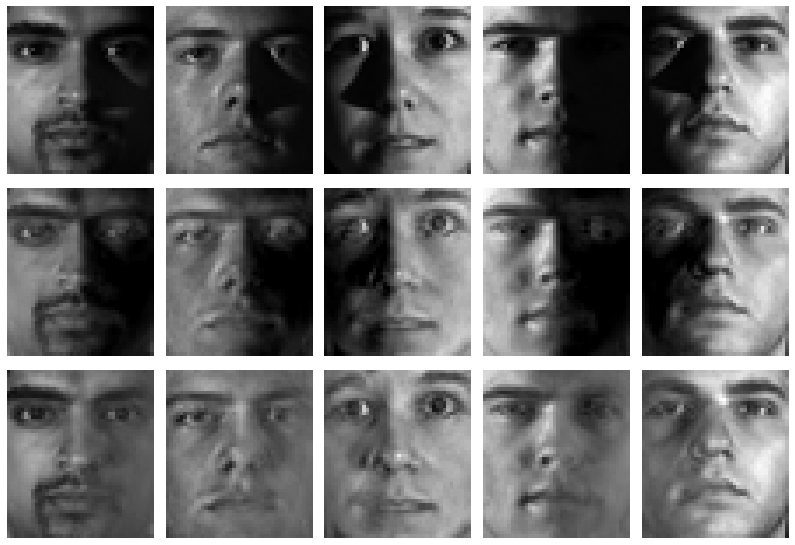

In [7]:
# List of example indices
example_idx_list = [6, 11, 16, 29, 34]

# Plot reconstructions
plot_recon_ex(example_idx_list=example_idx_list, scaler=scaler_X)

# Show plot
plt.subplots_adjust(wspace=0.08, hspace=0.01)
plt.show()


### **Reconstruct face images** - Original, PCA reconstruction, and aAPCA reconstruction (set 2)

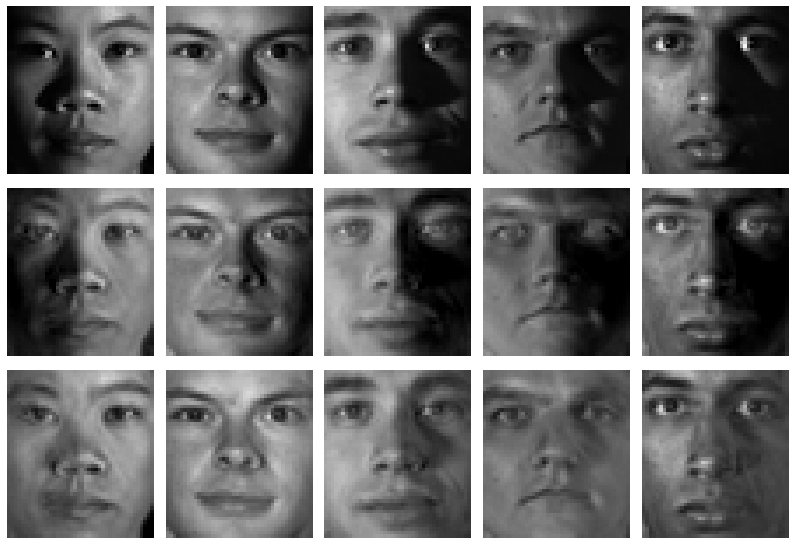

In [8]:
# List of example indices
example_idx_list = [39, 46, 74, 79, 91]

# Plot reconstructions
plot_recon_ex(example_idx_list=example_idx_list, scaler=scaler_X)

# Show plot
plt.subplots_adjust(wspace=0.08, hspace=0.01)
plt.show()


### **Reconstruct face images** - Original, PCA reconstruction, and aAPCA reconstruction (set 3)

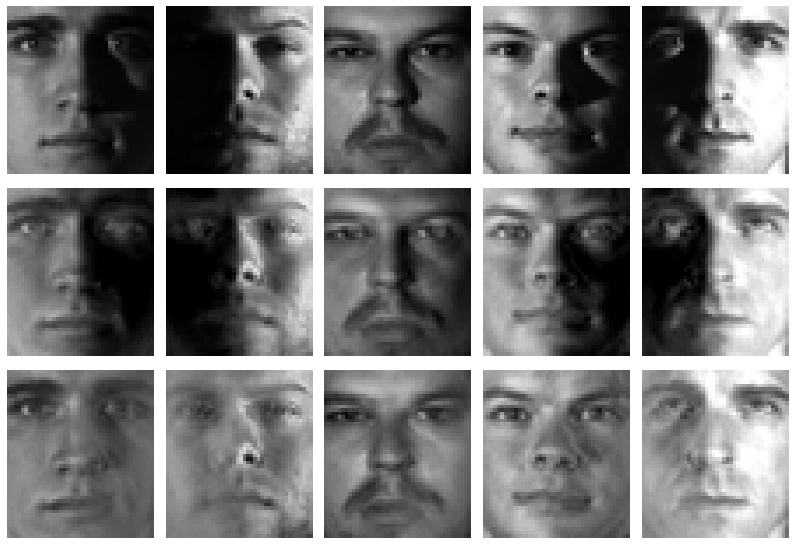

In [9]:
# List of example indices
example_idx_list = [100, 102, 103, 108, 109]

# Plot reconstructions
plot_recon_ex(example_idx_list=example_idx_list, scaler=scaler_X)

# Show plot
plt.subplots_adjust(wspace=0.08, hspace=0.01)
plt.show()


### **Reconstruct face images** - Original, PCA reconstruction, and aAPCA reconstruction (set 4)

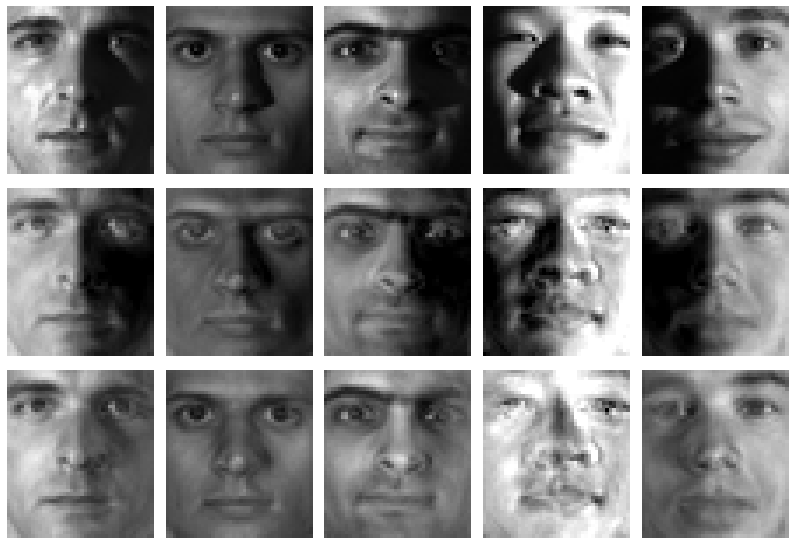

In [10]:
# List of example indices
example_idx_list = [140, 141, 158, 160, 161]

# Plot reconstructions
plot_recon_ex(example_idx_list=example_idx_list, scaler=scaler_X)

# Show plot
plt.subplots_adjust(wspace=0.08, hspace=0.01)
plt.show()


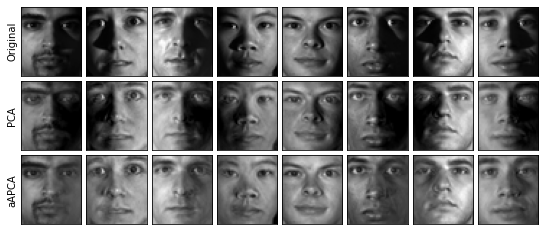

In [48]:
# List of example indices
example_idx_list = [6, 16, 140, 39, 46, 91, 34, 74]

# Initialize figure
fig, ax = plt.subplots(nrows=3, ncols=X_test_scaled[example_idx_list, :].shape[0], figsize=(9.3, 4))

# Iterate over test instances
for i, example_idx in enumerate(example_idx_list):
    # Original image
    img_orig_arr = X_test_scaled[[example_idx], :]
    img_orig_arr = scaler_X.inverse_transform(img_orig_arr)
    img_orig_arr = np.reshape(img_orig_arr, newshape=(img_height, img_width))
    img_orig = Image.fromarray(img_orig_arr)

    # PCA image reconstruction
    img_recon_pca_arr = S_pca[[example_idx], :] @ pca.components_ + scaler_X.data_scaled_mean_
    img_recon_pca_arr = scaler_X.inverse_transform(img_recon_pca_arr)
    img_recon_pca_arr = np.reshape(img_recon_pca_arr, newshape=(img_height, img_width))
    img_recon_pca_arr = ref_img_adjust(img_orig_arr, img_recon_pca_arr, ccmt=Y_test_scaled[[example_idx], :],
                                       ccmt_thresh=0.5, copy=True)
    img_recon_pca = Image.fromarray(img_recon_pca_arr)

    # Local aPCA image reconstruction
    img_recon_aapca_arr, _ = aapca.reconstruct(X_test_scaled[[example_idx], :], Y_test_scaled[[example_idx], :])
    img_recon_aapca_arr = scaler_X.inverse_transform(img_recon_aapca_arr)
    img_recon_aapca_arr = np.reshape(img_recon_aapca_arr, newshape=(img_height, img_width))
    img_recon_aapca_arr = ref_img_adjust(img_orig_arr, img_recon_aapca_arr, ccmt=Y_test_scaled[[example_idx], :],
                                         ccmt_thresh=0.5, copy=True)
    img_recon_aapca = Image.fromarray(img_recon_aapca_arr)

    # Display image and reconstructions
    ax[0, i].imshow(img_orig)
    ax[1, i].imshow(img_recon_pca)
    ax[2, i].imshow(img_recon_aapca)

    # No axis tickmarks
    ax[0, i].set_xticks([])
    ax[1, i].set_xticks([])
    ax[2, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_yticks([])
    ax[2, i].set_yticks([])

frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

# Row labels
ax[0, 0].set_ylabel('Original')
ax[1, 0].set_ylabel('PCA')
ax[2, 0].set_ylabel('aAPCA')

# Plot attributes
# fig.suptitle('Image Reconstruction - Azimuth Invariance')

# Show plot
plt.subplots_adjust(wspace=0.05, hspace=0.08)
plt.show()

# Save figure
dpi = 600
fig.savefig('figures/yale_face_recon.pdf', bbox_inches='tight', dpi=dpi)


### **Reconstructed face images** - Original vs aAPCA reconstructions

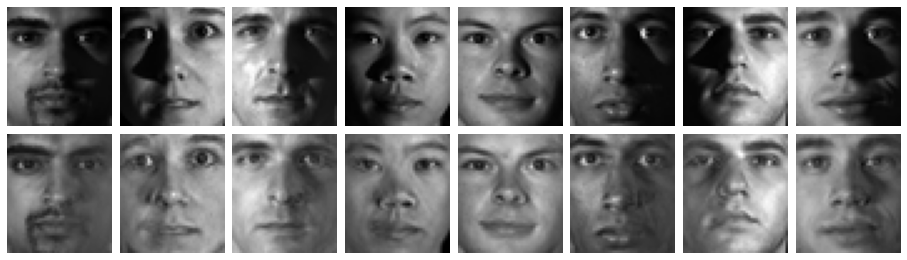

In [36]:
# List of example indices
example_idx_list = [6, 16, 140, 39, 46, 91, 34, 74]

# Initialize figure
fig, ax = plt.subplots(nrows=2, ncols=X_test_scaled[example_idx_list, :].shape[0], figsize=(16, 4.63))

# Iterate over test instances
for i, example_idx in enumerate(example_idx_list):
    # Original image
    img_orig_arr = X_test_scaled[[example_idx], :]
    img_orig_arr = scaler_X.inverse_transform(img_orig_arr)
    img_orig_arr = np.reshape(img_orig_arr, newshape=(img_height, img_width))
    img_orig = Image.fromarray(img_orig_arr)

    # PCA image reconstruction
    img_recon_pca_arr = S_pca[[example_idx], :] @ pca.components_ + scaler_X.data_scaled_mean_
    img_recon_pca_arr = scaler_X.inverse_transform(img_recon_pca_arr)
    img_recon_pca_arr = np.reshape(img_recon_pca_arr, newshape=(img_height, img_width))
    img_recon_pca_arr = ref_img_adjust(img_orig_arr, img_recon_pca_arr, ccmt=Y_test_scaled[[example_idx], :],
                                       ccmt_thresh=0.5, copy=True)
    img_recon_pca = Image.fromarray(img_recon_pca_arr)

    # Local aPCA image reconstruction
    img_recon_aapca_arr, _ = aapca.reconstruct(X_test_scaled[[example_idx], :], Y_test_scaled[[example_idx], :])
    img_recon_aapca_arr = scaler_X.inverse_transform(img_recon_aapca_arr)
    img_recon_aapca_arr = np.reshape(img_recon_aapca_arr, newshape=(img_height, img_width))
    img_recon_aapca_arr = ref_img_adjust(img_orig_arr, img_recon_aapca_arr, ccmt=Y_test_scaled[[example_idx], :],
                                         ccmt_thresh=0.5, copy=True)
    img_recon_aapca = Image.fromarray(img_recon_aapca_arr)

    # Display image and reconstructions
    ax[0, i].imshow(img_orig)
    # ax[1, i].imshow(img_recon_pca)
    ax[1, i].imshow(img_recon_aapca)

    # No axis tickmarks
    ax[0, i].axis('off')
    # ax[1, i].axis('off')
    ax[1, i].axis('off')

# Plot attributes
#  fig.suptitle('Image Reconstruction - Azimuth Invariance')

# Show plot
plt.subplots_adjust(wspace=0.08, hspace=0.01)
plt.show()

# Save figure
dpi = 600
fig.savefig('figures/yale_face_recon.pdf', bbox_inches='tight', dpi=dpi)


### **t-SNE clustering of PCA and aAPCA image reconstructions**

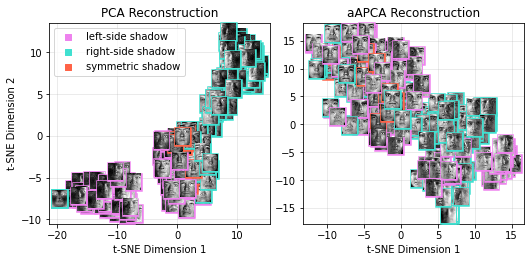

In [48]:
# Number of components for PCA and aPCA models
n_components = 100

# aAPCA adversarial strength
mu = 20000

# Instantiate UMAP and t-SNE models
tsne = TSNE(n_components=2, random_state=random_state)
umap = UMAP(n_components=2, random_state=random_state)

# PCA image reconstructions
pca = PCA(n_components=n_components)
pca.fit(X_train_scaled)
S_pca = pca.transform(X_test_scaled)
img_recon_pca = S_pca[:, :] @ pca.components_ + scaler_X.data_scaled_mean_
img_recon_pca = scaler_X.inverse_transform(img_recon_pca)

# aAPCA image reconstructions
aapca = aAPCA(n_components=n_components, mu=mu, inference='joint')
aapca.fit(X_train_scaled, Y_train_scaled)
S_aapca = aapca.transform(X_test_scaled, Y_test_scaled)
img_recon_aapca, _ = aapca.reconstruct(X_test_scaled[:, :], Y_test_scaled[:, :])
# img_recon_aapca = (img_recon_aapca + X_train_min) * (X_train_max - X_train_min)
img_recon_aapca = scaler_X.inverse_transform(img_recon_aapca)

# Non-linear manifold-based decomposition
# S_pca_recon = scale(umap.fit_transform(img_recon_pca))
# S_aapca_recon = scale(umap.fit_transform(img_recon_aapca))
S_pca_recon = (tsne.fit_transform(img_recon_pca / 255.0))
S_aapca_recon = (tsne.fit_transform(img_recon_aapca / 255.0))

# Initialize plot
fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(8.5, 3.7))

# Plot properties
zoom = 0.35
annotate_offset = 0.1
border_width = 2.5
# edge_color_dict = {0: 'lightcoral', 0.5: 'mediumturquoise', 1.0: 'mediumslateblue'}
# edge_color_dict = {0: 'tomato', 0.5: 'limegreen', 1.0: 'dodgerblue'}
edge_color_dict = {0: 'violet', 0.5: 'tomato', 1.0: 'turquoise'}
annotate_id = False

# Plot reconstructed test images in t-SNE space
for i in range(X_test.shape[0]):
    # Original image
    img_orig_arr = X_test_scaled[[i], :]
    img_orig_arr = scaler_X.inverse_transform(img_orig_arr)
    img_orig_arr = np.reshape(img_orig_arr, newshape=(img_height, img_width))

    # Plot PCA-reconstructed image in t-SNE space
    img_recon_arr = np.reshape(img_recon_pca[i, :], newshape=(img_height, img_width))
    img_recon_arr = ref_img_adjust(img_orig_arr, img_recon_arr, ccmt=Y_test_scaled[[i], :],
                                       ccmt_thresh=0.5, copy=True)
    offset_img = OffsetImage(img_recon_arr, cmap='gray', zoom=zoom)
    ab_pca = AnnotationBbox(offset_img, (S_pca_recon[i, 0], S_pca_recon[i, 1]),
                            xycoords='data', pad=0.0, frameon=True,
                            bboxprops=dict(edgecolor=edge_color_dict[labels_shadow_test[i]],
                                           linewidth=border_width))
    ax3[0].add_artist(ab_pca)
    ax3[0].scatter(S_pca_recon[i, 0], S_pca_recon[i, 1])
    
    # Plot aAPCA-reconstructed image in t-SNE space
    img_recon_arr = np.reshape(img_recon_aapca[i, :], newshape=(img_height, img_width))
    img_recon_arr = ref_img_adjust(img_orig_arr, img_recon_arr, ccmt=Y_test_scaled[[i], :],
                                       ccmt_thresh=0.5, copy=True)
    offset_img = OffsetImage(img_recon_arr, cmap='gray', zoom=zoom)
    ab_aapca = AnnotationBbox(offset_img, (S_aapca_recon[i, 0], S_aapca_recon[i, 1]),
                              xycoords='data', pad=0.0, frameon=True,
                              bboxprops=dict(edgecolor=edge_color_dict[labels_shadow_test[i]],
                                             linewidth=border_width))
    ax3[1].add_artist(ab_aapca)
    ax3[1].scatter(S_aapca_recon[i, 0], S_aapca_recon[i, 1])
    
    # Add ID annotations
    if annotate_id:
        ax3[0].annotate(str(labels_id_test[i]),
                        (S_pca_recon[i, 0] + annotate_offset, S_pca_recon[i, 1] + annotate_offset),
                           xycoords='data')
        ax3[1].annotate(str(labels_id_test[i]),
                        (S_aapca_recon[i, 0] + annotate_offset, S_aapca_recon[i, 1] + annotate_offset),
                           xycoords='data')

# Axis labels
# fig3.suptitle('t-SNE Clustering of Reconstructed Face Images')
ax3[0].set_title('PCA Reconstruction')
ax3[1].set_title('aAPCA Reconstruction')
ax3[0].set_xlabel('t-SNE Dimension 1')
ax3[0].set_ylabel('t-SNE Dimension 2')
ax3[1].set_xlabel('t-SNE Dimension 1')


# Legend
ax3[0].scatter(np.nan, np.nan, c='violet', marker='s', label='left-side shadow')
ax3[0].scatter(np.nan, np.nan, c='turquoise', marker='s', label='right-side shadow')
ax3[0].scatter(np.nan, np.nan, c='tomato', marker='s', label='symmetric shadow')
ax3[0].legend(loc='upper left')

# Grid lines
ax3[0].grid(alpha=0.3)
ax3[1].grid(alpha=0.3)
ax3[0].set_axisbelow(True)
ax3[1].set_axisbelow(True)

plt.subplots_adjust(wspace=0.15)
plt.show()


dpi = 600
fig3.savefig('figures/yale_face_tsne_cluster.pdf', bbox_inches='tight', dpi=dpi)
